**Clicked Advanced Machine Learning: Multi-linear Regression**

In [1]:
#import libraries--may not use all of them
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols

import patsy
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

**Import Data**

In [2]:
data = "/content/ClickedDemostration_PredictiveAnalytics.csv"
#column_names = ['Car_Make', 'Year', 'Selling_Price (in 000s)', 'Present_Price  (in 000s)', 'KM_Driven',
               # 'Fuel_Type', 'Fuel_Type_Category', 'Seller_Type', 'Seller_Type_Category', 'Transmission'#
                #'Transmission_Category','Owner','Owner_Category']#

raw_dataset = pd.read_csv(data)

In [3]:
dataset = raw_dataset.copy()
dataset.head()

,Car_Make,Year,Selling_Price (in 000s),Present_Price (in 000s),KM_Driven,Fuel_Type,Fuel_Type_Category,Seller_Type,Seller_Type_Category,Transmission,Transmission_Category,Owner,Owner_Category
0,ritz,2014,3.35,5.59,27000,1,Petrol,1,Dealer,1,Manual,0,New
1,sx4,2013,4.75,9.54,43000,2,Diesel,1,Dealer,1,Manual,0,New
2,ciaz,2017,7.25,9.85,6900,1,Petrol,1,Dealer,1,Manual,0,New
3,wagon r,2011,2.85,4.15,5200,1,Petrol,1,Dealer,1,Manual,0,New
4,swift,2014,4.60,6.87,42450,2,Diesel,1,Dealer,1,Manual,0,New


**Check for NA Values and Drop if Need Be**

In [4]:
dataset.isna().sum()


Car_Make                    0
Year                        0
Selling_Price (in 000s)     0
Present_Price  (in 000s)    0
KM_Driven                   0
Fuel_Type                   0
Fuel_Type_Category          0
Seller_Type                 0
Seller_Type_Category        0
Transmission                0
Transmission_Category       0
Owner                       0
Owner_Category              0
dtype: int64

In [ ]:
dataset = dataset.dropna()

**One hot encoding**


In [5]:
#Create category maps--done separately since each is a different dictionary
dataset['Seller_Type_Category'] = dataset['Seller_Type_Category'].map({1: 'Dealer', 2: 'Individual'})
dataset['Transmission_Category'] = dataset['Transmission_Category'].map({1: 'Manual', 2: 'Automatic'})
dataset['Fuel_Type_Category'] = dataset['Fuel_Type_Category'].map({1: 'Petrol', 2: 'Diesel', 3: 'CNG'})
dataset['Owner_Category'] = dataset['Owner_Category'].map({0: 'New', 1: 'One', 2: 'Two', 3: 'Three'})

In [6]:
#One hot encode variables
dataset = pd.get_dummies(dataset, columns=['Seller_Type_Category', 'Transmission_Category',
                                           'Fuel_Type_Category', 'Owner_Category'], prefix='', prefix_sep='')

**Split data into test, validation, and training sets**

In [7]:
# Split into training and testing sets--80/20
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

'''
Split the training set again into training and validation sets (e.g., 70/30 split)
train_dataset, val_dataset = train_dataset.sample(frac=0.7, random_state=0).reset_index(drop=True),
train_dataset.drop(train_dataset.index).reset_index(drop=True)
'''

'\nSplit the training set again into training and validation sets (e.g., 70/30 split)\ntrain_dataset, val_dataset = train_dataset.sample(frac=0.7, random_state=0).reset_index(drop=True),\ntrain_dataset.drop(train_dataset.index).reset_index(drop=True)\n'

In [8]:
#Review the training and test set
train_dataset.head()

,Car_Make,Year,Selling_Price (in 000s),Present_Price (in 000s),KM_Driven,Fuel_Type,Seller_Type,Transmission,Owner
587,KTM RC390,2011,17.1,16.70,17904,3,1,1,3
33,ertiga,2014,6.0,9.95,45000,2,1,1,0
891,i20,2023,17.3,15.90,80350,2,2,2,1
3085,s cross,2022,5.5,5.30,52914,1,2,1,2
1148,KTM RC200,2022,17.8,18.50,29409,1,2,2,3


**Inspect data**



In [9]:
#Check for non-numerical information and convert to categorical data
def check_non_numerical_columns(datasets):
  for dataset in datasets:
    for column in dataset.columns:
      if train_dataset[column].dtype == 'object':
        print(f"Non-numerical data found in column: {column}")
        print(train_dataset[column].unique())# Added and will test
        print()

check_non_numerical_columns([train_dataset, test_dataset])

Non-numerical data found in column: Car_Make
['KTM RC390' 'ertiga' 'i20' 's cross' 'KTM RC200' 'Honda CB Trigger'
 'TVS Jupyter' 'Yamaha FZ  v 2.0' 'Yamaha Fazer ' 'Suzuki Access 125'
 'Hero Super Splendor' 'Royal Enfield Classic 350' 'innova'
 'Honda CB Unicorn' 'city' 'jazz' 'Honda CB Hornet 160R' 'Yamaha FZ S '
 'vitara brezza' 'Hero Honda CBZ extreme' 'xcent' 'land cruiser'
 'Royal Enfield Bullet 350' 'Hyosung GT250R' 'Hero Honda Passion Pro'
 'omni' 'Mahindra Mojo XT300' 'Royal Enfield Thunder 500'
 'Honda Activa 4G' 'verna' 'Yamaha FZ 16' 'Hero Splender iSmart'
 'TVS Sport ' 'Hero Passion Pro' 'Honda Dream Yuga ' 'sx4' 'i10'
 'Honda Karizma' 'Hero Hunk' 'ignis' 'ritz' 'KTM 390 Duke '
 'Hero Splender Plus' 'swift' 'wagon r' 'Royal Enfield Classic 500'
 'amaze' 'Honda Activa 125' 'TVS Apache RTR 160' 'alto 800'
 'Hero Passion X pro' 'TVS Wego' 'Honda CBR 150' 'TVS Apache RTR 180'
 'UM Renegade Mojave' 'Honda CB Shine' 'Activa 3g' 'Yamaha FZ S V 2.0'
 'Royal Enfield Thunder 350' 'Ho

In [10]:
#Update columns to categorical
train_dataset['Car_Make'] = train_dataset['Car_Make'].astype('category')
test_dataset['Car_Make'] = test_dataset['Car_Make'].astype('category')

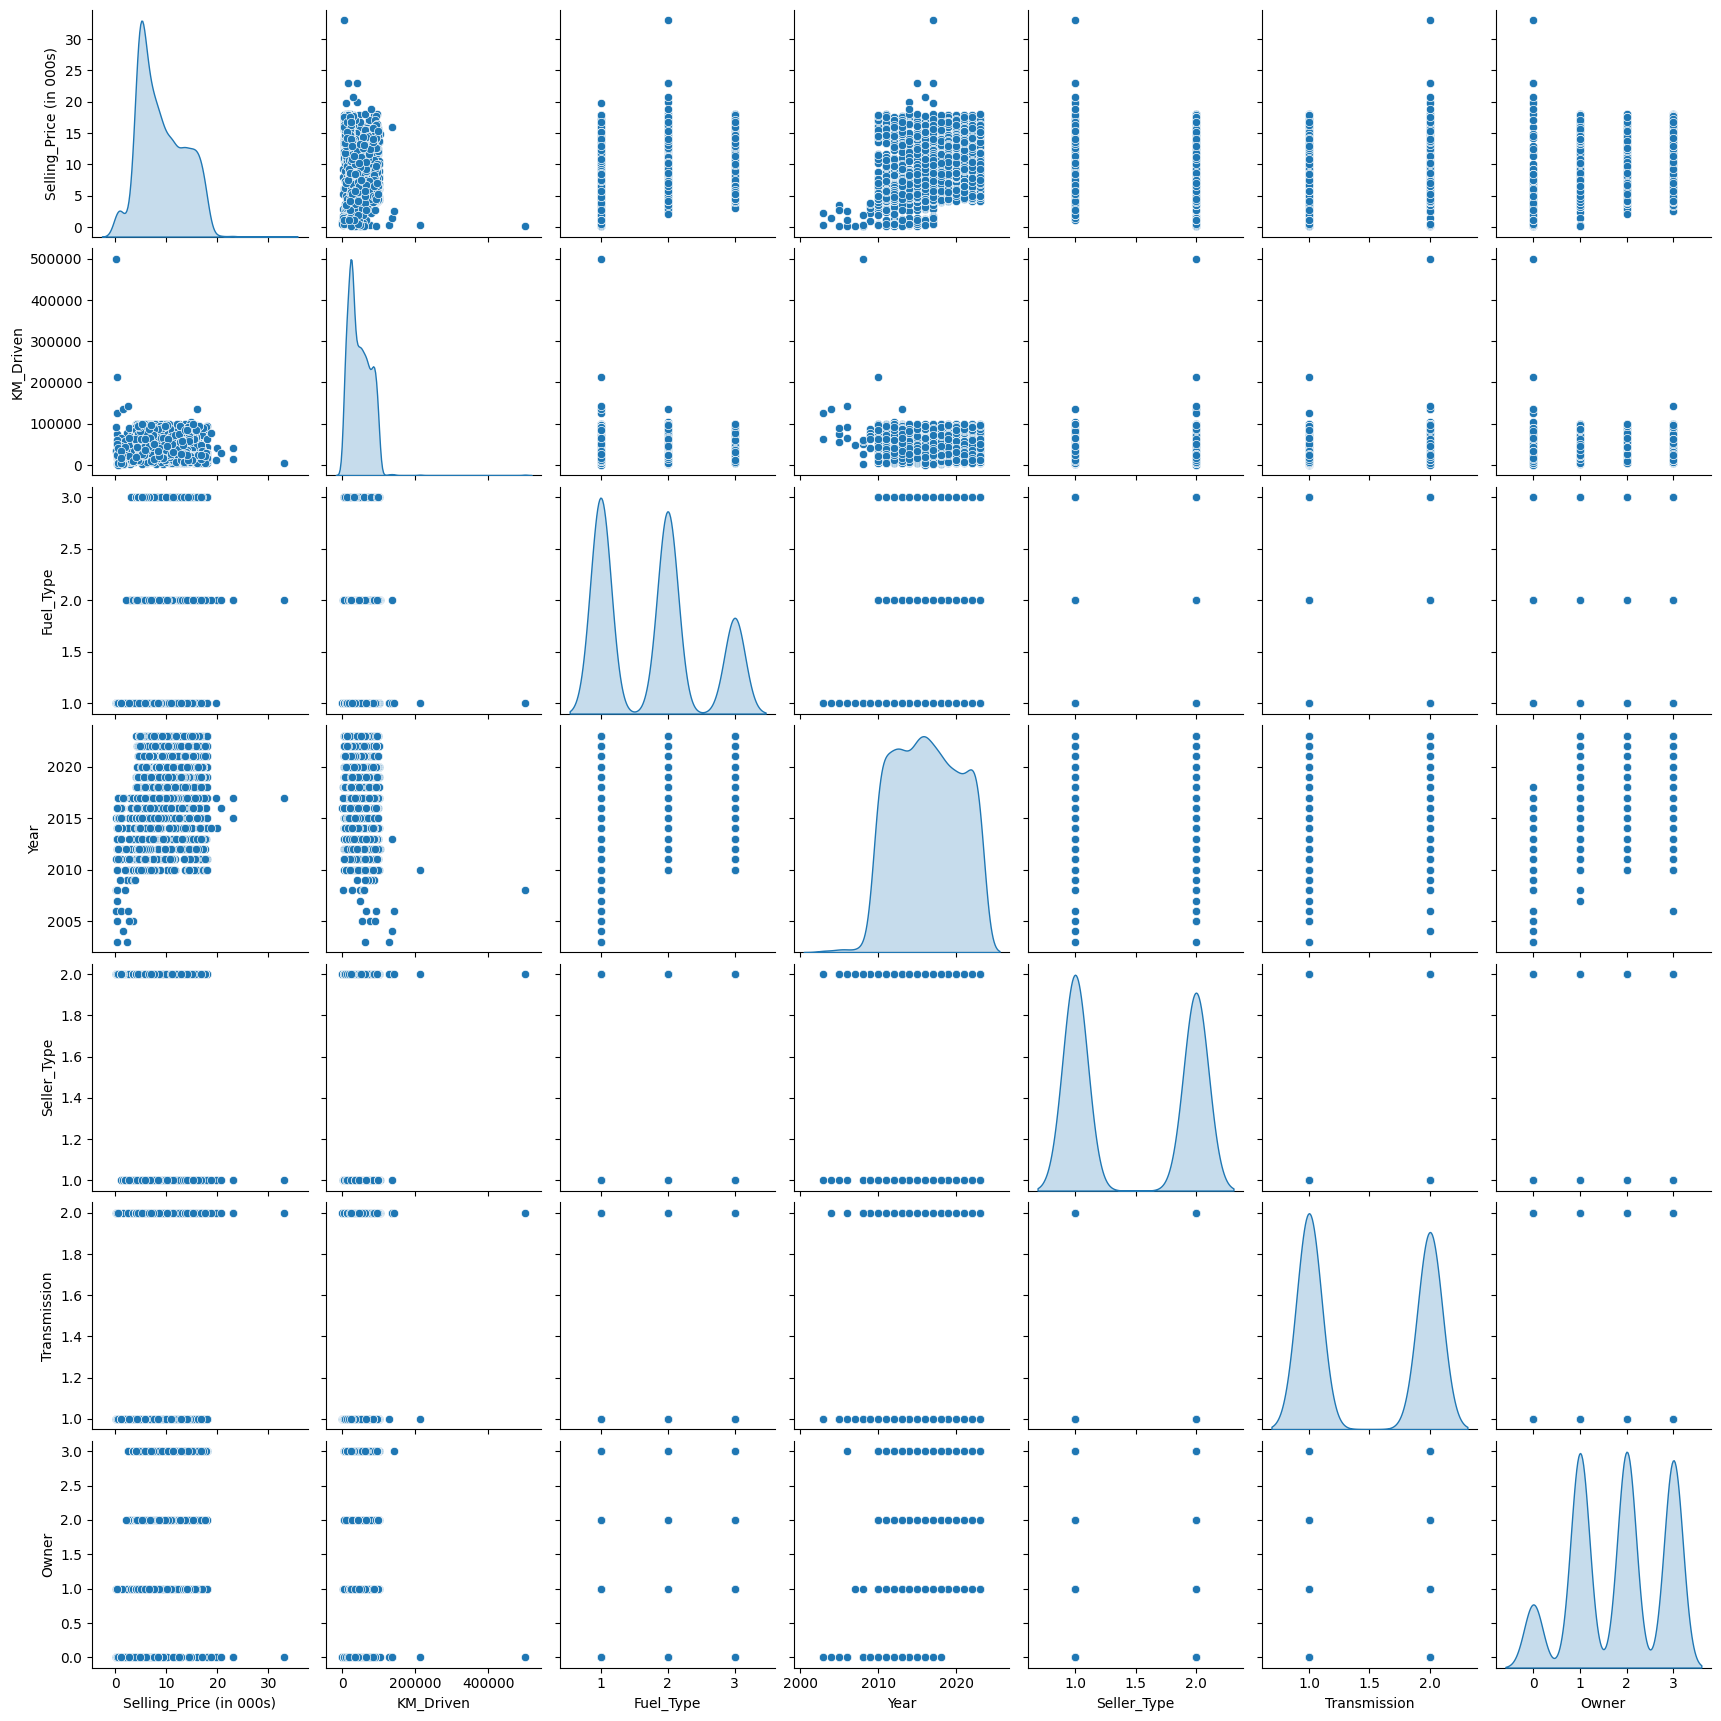

In [11]:
#Review joint distribution
sns.pairplot(train_dataset[['Selling_Price (in 000s)', 'KM_Driven', 'Fuel_Type', 'Year', 'Seller_Type',
                            'Transmission','Owner']], diag_kind='kde')
plt.show()


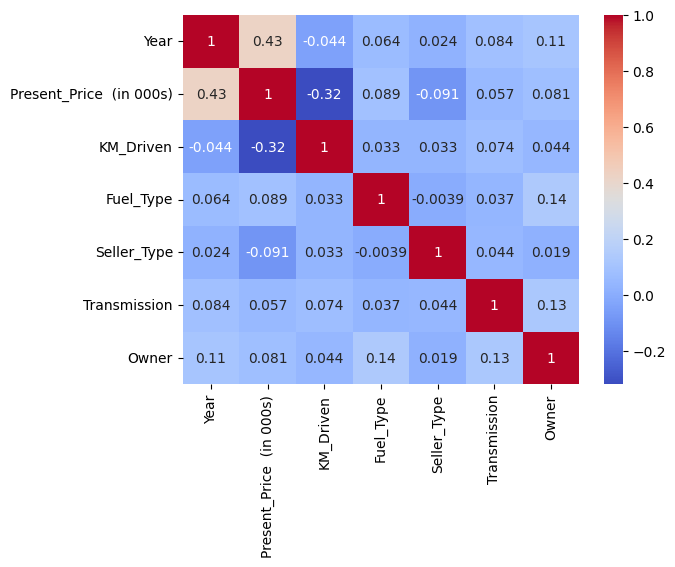

In [12]:
#Check for multi-collinearity
train_dataset.describe().transpose()
def plot_correlation_matrix(train_dataset,exclude_columns=['Car_Make', 'Selling_Price (in 000s)']):
  corr_matrix = train_dataset.drop(exclude_columns, axis=1).corr()
  sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
  plt.show()

plot_correlation_matrix(train_dataset)

In [13]:
# Create train_anova dataset to ensure data integrity
def train_anova(train_dataset):
  anova_data = train_dataset[['Car_Make', 'Selling_Price (in 000s)']].copy()
  anova_data.rename(columns={'Selling_Price (in 000s)': 'Selling_Price_in_000s'}, inplace=True)
  return anova_data

  anova_data = train_anova(train_dataset)


In [14]:
# Fit an ANOVA model to determine if strong relation btw Car_Make and Price
anova_data = train_anova(train_dataset)
anova_model = ols('Selling_Price_in_000s ~ C(Car_Make)', data=anova_data).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=1)

# Print the ANOVA table
print(anova_table)

                 df        sum_sq    mean_sq         F        PR(>F)
C(Car_Make)    96.0   5364.829358  55.883639  2.987635  2.010661e-19
Residual     2543.0  47566.745622  18.704973       NaN           NaN


In [ ]:
'''
Create Scatterplot
target_variable = 'Car_Make'
feature_list = ['KM_Driven', 'Fuel_Type', 'Year', 'Seller_Type',
                'Transmission', 'Owner']
for feature in feature_list:
        sns.scatterplot(x=feature, y=target_variable, data=train_dataset)
        plt.title(f"Scatter Plot: {target_variable} vs. {feature}")
        plt.show()

print(cate_scatter_plot(train_dataset))
'''

In [15]:
#Drop Car_Make from datasets
train_dataset = train_dataset.drop(columns=['Car_Make'])
test_dataset = test_dataset.drop(columns=['Car_Make'])

**Split features from labels**

In [16]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Selling_Price (in 000s)')
test_labels = test_features.pop('Selling_Price (in 000s)')

In [17]:
print(train_dataset.head)

<bound method NDFrame.head of       Year  Selling_Price (in 000s)  Present_Price  (in 000s)  KM_Driven  \
587   2011                    17.10                     16.70      17904   
33    2014                     6.00                      9.95      45000   
891   2023                    17.30                     15.90      80350   
3085  2022                     5.50                      5.30      52914   
1148  2022                    17.80                     18.50      29409   
...    ...                      ...                       ...        ...   
337   2018                    10.20                      9.60      46728   
46    2013                     2.65                      4.89      64532   
747   2019                    12.90                     12.30      27575   
3008  2019                     7.00                      6.10      96072   
753   2018                    16.70                     16.80      24924   

      Fuel_Type  Seller_Type  Transmission  Owner  
587  

**Normalize the data**

In [18]:
#Create normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)

#Normalize the data by fitting to the preprocessing layer
normalizer.adapt(np.array(train_features))

#Calculate the mean and variance, and store them in the layer:
print(normalizer.mean.numpy())

#When called, will produce input data with all features independently normalized
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())



[[2.0162753e+03 8.8176193e+00 4.6430844e+04 1.7662880e+00 1.4784092e+00
  1.4772729e+00 1.8094698e+00]]
First example: [[ 2011.     16.7 17904.      3.      1.      1.      3. ]]

Normalized: [[-1.29  1.72 -0.98  1.66 -0.96 -0.96  1.24]]


**Build Multi-Linear Regression**

In [19]:
#Review shape of all printouts
print("train_features shape:", train_features.shape)
print("train_labels shape:", train_labels.shape)
print("test_features shape:", test_features.shape)
print("test_labels shape:", test_labels.shape)

train_features shape: (2640, 7)
train_labels shape: (2640,)
test_features shape: (660, 7)
test_labels shape: (660,)


In [20]:
#First, build and train multi-linear model
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1),
    #layers.Input(shape=(7,))#
])

#Call model.predict
linear_model.predict(train_features[:9])

#Confirm kernal weights--should be (8,1)
linear_model.layers[1].kernel

#Compile the model
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

#%%time#
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=50,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)



1/1 [==============================] - 0s 140ms/step


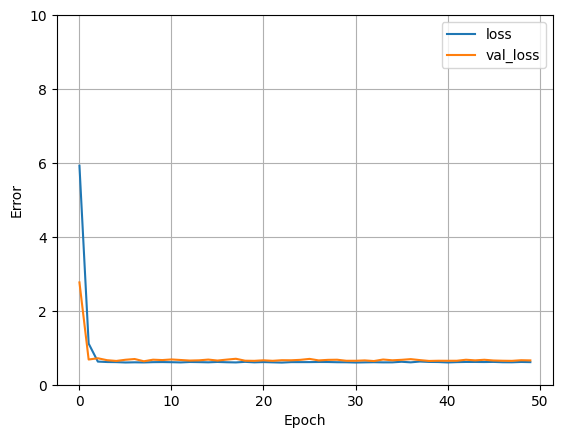

In [21]:
#Plot loss history
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [22]:
#Collect Results

#print(plot_model(linear_model))
test_results = {}
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

print(test_results)

{'linear_model': 0.6473436951637268}


In [23]:
#Show linear_model equation

#Get weights (coefficients)
coefficients = linear_model.layers[1].kernel.numpy().flatten()
#print(coefficients)


#Get bias (intercept)
intercept = linear_model.layers[1].bias.numpy()
#print(intercept)

#Get number of features
num_features = train_features.shape[1]
#print(num_features)

#Construct Equation
def model_equation(coefficients, intercept, train_features, num_features):
  equation = f"Predicted_Value = {intercept[0]:.2f} "  # Adjust formatting as needed
  for i in range(num_features):
    sign = "+" if coefficients[i] >= 0 else "-"
    equation += f" {sign} {abs(coefficients[i]):.2f} * {train_features.columns[i]} "
  print("Equation:", equation)
  return equation

result = model_equation(coefficients, intercept, train_features, num_features)
print(result)


Equation: Predicted_Value = 9.15  + 0.18 * Year  + 4.54 * Present_Price  (in 000s)  + 0.17 * KM_Driven  + 0.17 * Fuel_Type  + 0.04 * Seller_Type  + 0.01 * Transmission  + 0.12 * Owner 
Predicted_Value = 9.15  + 0.18 * Year  + 4.54 * Present_Price  (in 000s)  + 0.17 * KM_Driven  + 0.17 * Fuel_Type  + 0.04 * Seller_Type  + 0.01 * Transmission  + 0.12 * Owner 


In [24]:
#Check features and label shape
print(f"test_features shape: {test_features.shape}")
print(f"test_labels shape: {test_labels.shape}")

test_features shape: (660, 7)
test_labels shape: (660,)


**BONUS: MultiLinear Regression with Deep Neural Network**

In [25]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [26]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

##%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=50)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 7)                 15        
 on)                                                             
                                                                 
 dense_1 (Dense)             (None, 64)                512       
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4752 (18.57 KB)
Trainable params: 4737 (18.50 KB)
Non-trainable params: 15 (64.00 Byte)
_________________________________________________________________


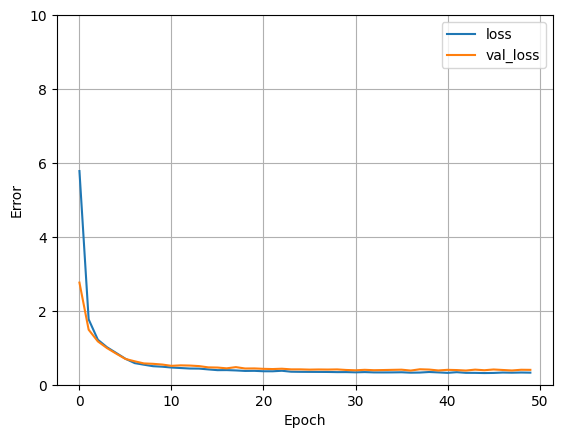

In [27]:
#Plot loss history
plot_loss(history)

In [28]:
#Collect results
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

**Performance**

In [29]:
#Review Linear vs. DNN Model
pd.DataFrame(test_results,
             index=['Mean absolute error [Selling_Price (in 000s)]']).T

,Mean absolute error [Selling_Price (in 000s)]
linear_model,0.647344
dnn_model,0.425920


**Make Predictions and review the model**

21/21 [==============================] - 0s 5ms/step


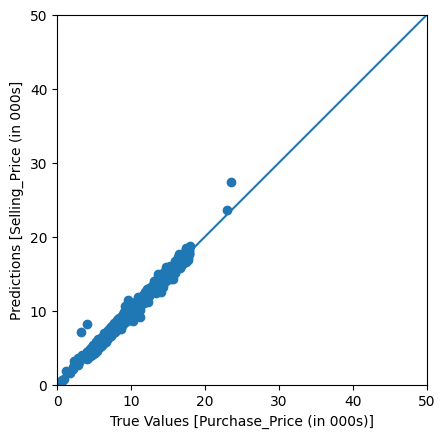

In [36]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Purchase_Price (in 000s)]')
plt.ylabel('Predictions [Selling_Price (in 000s]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

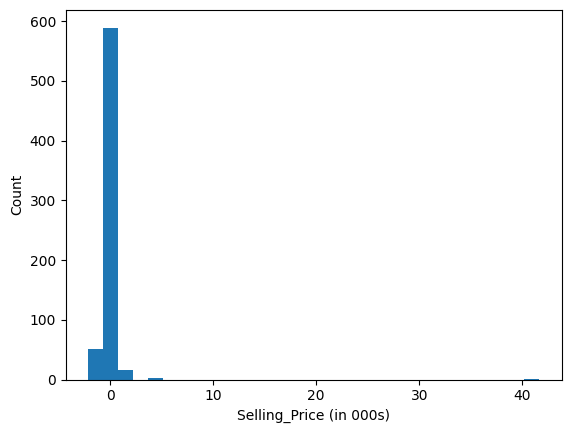

In [38]:
#View error terms
error = test_predictions - test_labels
plt.hist(error, bins=30)
plt.xlabel('Selling_Price (in 000s)')
_ = plt.ylabel('Count')

In [32]:
#Save model
dnn_model.save('dnn_model.keras')

In [34]:
#Review results
pd.DataFrame(test_results, index=['Selling_Price (in 000s)']).T

,Selling_Price (in 000s)
linear_model,0.647344
dnn_model,0.425920
